# Đồ án 1: Color Compression
### Mã số sinh viên: 21127657
### Họ tên: Nguyễn Khánh Nhân
### Lớp: 21CLC02
---

# A. Mã nguồn của toàn bộ chương trình

In [14]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time

def calc_distances(X, Y):
    """
    Tính khoảng cách Euclid giữa các điểm ảnh trong ma trận X và các centroids trong ma trận Y.
    Input:
        X: ma trận có kích thước (m, n), m là số lượng điểm (pixel), n là số chiều của mỗi điểm (số kênh màu).
        Y: ma trận có kích thước (k, n), k là số lượng centroids, n là số chiều của mỗi điểm (số kênh màu).
    Output:
        ma trận chứa các khoảng cách có kích thước (m, k).
    """
    m = X.shape[0]
    k = Y.shape[0]
    distances = np.zeros((m, k))
    for i in range(m):
        for j in range(k):
            distances[i, j] = np.linalg.norm(X[i]-Y[j])
    return distances

def grouping_pixels_1(i, labels):
    """
    Thực hiện gom nhóm các điểm ảnh thuộc nhóm đang xét nhờ kĩ thuật dùng mảng boolean hay
    còn gọi là mask trong numpy.
    
    Input:
        i: index của nhóm đang xét
        labels: mảng labels của các điểm ảnh
    Output: 
        list chứa các index của các điểm ảnh thuộc nhóm i
    """
    return [j for j in range(labels.shape[0]) if labels[j] == i]

def grouping_pixels_2(i, labels):
    """
    Thực hiện gom nhóm các điểm ảnh thuộc nhóm đang xét nhờ kĩ thuật dùng mảng boolean hay
    còn gọi là mask trong numpy.
    
    Input:
        i: index của nhóm đang xét
        labels: mảng labels của các điểm ảnh
        img_1d: mảng các điểm ảnh
    Output: 
        Mảng boolean cho biết điểm ảnh nào sẽ thuộc nhóm i
    """
    bool_arr = (labels == i)
    return  bool_arr
                

def kmeans(img_1d, k_clusters, max_iter=10, init_centroids="random"):
    """Sử dụng thuật toán K-Means để tìm các centroids"""
    
    # Khởi tạo các centroids
    if init_centroids == "random":
        centroids = np.random.randint(0, 266, size=(k_clusters, img_1d.shape[1])).astype('float')
    elif init_centroids == "in_pixels":
        centroids_index = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)
        centroids = img_1d[centroids_index].astype('float')
    else:
        raise ValueError("Cách khởi tạo centroid không hợp lệ!!")
    # Khởi tạo các label với giá trị -1
    labels = np.ones(shape=img_1d.shape[0]) * -1
    # Thực hiện gom nhóm và tính toán lại các centroids
    for _ in range(max_iter):
        # cách 1: sử dụng hàm calc_distances() tự viết => Tốn rất nhiều thời gian
        # distances = calc_distances(img_1d, centroids)
        
        # cách 2: sử dụng hàm norm có sẵn trong numpy.linalg
        distance_vectors = img_1d[:, np.newaxis] - centroids
        distances = np.linalg.norm(distance_vectors, axis=2)
        
        new_labels = np.argmin(distances, axis=1)
        # Nếu toàn bộ label của điểm ảnh không đổi thì ta sẽ dừng thuật toán K-Means ngay
        if np.array_equal(new_labels, labels):
            break
        # Lần lượt cập nhật lại k centroid mới
        for i in range(k_clusters):
            group_pixels = img_1d[grouping_pixels_2(i, new_labels)]
            if group_pixels.size > 0: 
                centroids[i] = np.mean(group_pixels, axis=0)
        # Cập nhật lại labels        
        labels = new_labels.copy()
        
    return centroids, labels

def get_input():
    """Lấy giá trị các input cần có trước khi thực hiện thuật toán K-means"""
    img_path = input("Nhập vào tên file ảnh: ")

    k_clusters = int(input("Nhập vào số lượng màu của ảnh mới: "))
    
    max_iter = int(input("Nhập vào số lần lặp tối đa cho K-Means (default = 10): "))
    
    init_centroids = input("Chọn cách khởi tạo các centroid (random/in_pixels): ")
    
    return img_path, k_clusters, max_iter, init_centroids


# Biến này chỉ lưu lại các input để các cell con dùng giải thích code bên dưới không bị lỗi
INPUTS = get_input()

def main():
    """Hàm main của chương trình"""
    
    # Lấy các input cần thiết
    img_path, k_clusters, max_iter, init_centroids = INPUTS
    
    # Đọc ảnh và thành ma trận các điểm ảnh
    img = Image.open(img_path)
    
    img_arr = np.array(img)
    
    img_1D_arr = img_arr.reshape(img_arr.shape[0]*img_arr.shape[1], img_arr.shape[2])
    # Sử dụng K-Means để tìm các centroid và label cho những điểm ảnh của ảnh gốc
    start = time.time()
    centroids, labels = kmeans(img_1D_arr.astype('float'), k_clusters, max_iter, init_centroids)
    end = time.time()
    # Thay màu của những điểm ảnh trong ảnh gốc bằng màu của centroid gần nhất
    img_1D_reduced = centroids[labels]

    # Chuyển ma trận điểm ảnh sau khi "nén màu" thành ảnh mới

    img_reduced = Image.fromarray(np.uint8(img_1D_reduced.reshape(img_arr.shape)))

    # Đo thời gian thực hiện K-means
    print(f"Running time: {end-start}")
    # Show ra ảnh sau khi giảm màu
    figure, ax = plt.subplots(1,2)
    ax[0].set_title("Ảnh gốc")
    ax[1].set_title(f"Ảnh sau khi nén còn {k_clusters} màu")
    ax[0].imshow(img)
    ax[1].imshow(img_reduced)
    # Lưu ảnh mới dưới dạng nào?
    output_format = input("Lưu ảnh dưới dạng: ")
    # Lưu ảnh 
    output_file = f"new_image.{output_format}"
    img_reduced.save(output_file)

Running time: 0.3190727233886719


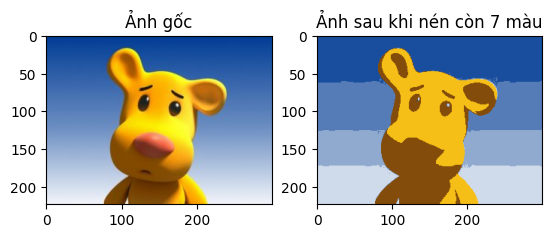

In [15]:
# Gọi hàm main
main()

---

# B. Giải thích mã nguồn của chương trình

## 0. Khai báo các thư viện sẽ sử dụng

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 1. Đọc ảnh thành ma trận 
* Ảnh sẽ được chuyển thành một ma trận 3 chiều có số dòng, số cột tương ứng với kích thước chiều dọc, ngang của bức ảnh và chiều cuối cùng là số kênh màu (channel).
     * VD: bức ảnh màu kích thước 3x4 sẽ được chuyển thành ma trận có 3 cột, 4 dòng, 3 kênh màu
* Mỗi một phần tử của ma trận này là 1 điểm ảnh có 3 giá trị đại diện cho 3 màu RED-GREEN-BLUE.
* Lưu ý: các giá trị kênh màu của từng điểm ảnh sẽ từ 0-255 cho nên chúng sẽ có kiểu dữ liệu là "unsigned int 8 bit". Chúng ta cần ép kiểu sang "float" trước khi đưa ma trận các điểm ảnh này vào hàm kmeans() vì trong hàm này ta sẽ sử dụng các hàm như norm(), mean() để thực hiện việc tính độ lớn vector, vector trung bình và chúng có thể cho ra các giá trị màu là số thực hoặc lớn hơn 255.

In [17]:
filename = INPUTS[0]
img = Image.open(filename)
img_arr = np.array(img)
img_1d_arr = img_arr.reshape(img_arr.shape[0]*img_arr.shape[1], img_arr.shape[2]).astype('float')

## 2. Thuật toán K-Mean
### 2.1 Tạo ra một mảng các centroids ban đầu:
*    Cách 1: Tạo các centroids có giá trị kênh màu ngẫu nhiên
*    Cách 2: Tạo các centroids bằng cách chọn ngẫu nhiên từ các điểm ảnh trong ảnh gốc

In [18]:
# Giả sử k = 3 centroids
k_clusters = 3
# Cách 1
centroids = np.random.randint(0, 266, size=(k_clusters, img_1d_arr.shape[1])).astype('float')
# Cách 2
centroids_index = np.random.choice(img_1d_arr.shape[0], size=k_clusters, replace=False)
centroids = img_1d_arr[centroids_index].astype('float')


### 2.2 Thực hiện gom nhóm các điểm ảnh để giảm số lượng màu của bức ảnh
* Bước 1: Tính khoảng cách Euclid từ các điểm ảnh tới K centroids có sẵn.
    * Áp dụng công thức Euclid ở phổ thông để tính khoảng cách giữa 2 điểm.

In [19]:
### Cách 1
def euclidean_distances(X, Y):
    """
    Tính khoảng cách Euclid giữa các điểm ảnh trong ma trận X và các centroids trong ma trận Y.
    Input:
        X: ma trận có kích thước (m, n), m là số lượng điểm (pixel), n là số chiều của mỗi điểm (số kênh màu).
        Y: ma trận có kích thước (k, n), k là số lượng centroids, n là số chiều của mỗi điểm (số kênh màu).
    Output:
        ma trận chứa các khoảng cách có kích thước (m, k).
    """
    m = X.shape[0]
    k = Y.shape[0]
    distances = np.zeros((m, k))
    for i in range(m):
        for j in range(k):
            distances[i, j] = np.linalg.norm(X[i]-Y[j])
    return distances


In [20]:
### Cách 2
distance_vectors = img_1d_arr[:, np.newaxis].astype('float') - centroids
distances = np.linalg.norm(distance_vectors, axis=2)

* Giải thích dòng code trên:
    * Dựa vào kết quả cách 1, ta biết là mảng "distances" là mảng 2 chiều chứa khoảng cách từ từng điểm ảnh đến tất cả centroid, "distances[i][j]" là khoảng cách từ điểm ảnh thứ i cho đến centroids thứ j.

    * Vì vậy trước nhất ta cần tạo ra ma trận 3 chiều chứa các vector khoảng cách, với 2 chiều đầu tiên (axis = 0, axis = 1) là vector khoảng cách của điểm ảnh và centroid tương ứng, chiều thứ 3 (axis = 2) chính là chiều chứa 3 tọa độ của vector khoảng cách. Cuối cùng chỉ cần tính norm theo chiều này (axis = 2) thì ta sẽ tìm được norm của từng vector khoảng cách cũng chính là độ dài của từng điểm ảnh tới các centroid.

    * "img_1d_arr" là 1 ma trận 2 chiều có kích thước (height x width, 3) nên "img_1d_arr[:, np.newaxis]" sẽ là 1 ma trận có dữ liệu giống như "img_1d_arr" nhưng giờ đây sẽ là 3 chiều (heiht x width, 1, 3).
    * "img_1d_arr[:, np.newaxis] - centroids" sẽ trả về các vector khoảng cách của từng điểm ảnh trong "img_1d_arr" cho tới TẤT CẢ các centroids. Vì vậy "distance_vectors" sẽ là ma trận 3 chiều kích thước (height x width, k_clusters, 3).
    
    * Cuối cùng để tính norm của các vector khoảng cách này, ta sẽ dùng hàm được cấp sẵn trong thư viện numpy là np.linalg.norm(). Lưu ý phải gán tham số "axis" = 2 vì trục axis = 2 chính là trục chứa các tọa độ của vector khoảng cách, nên việc sử dụng hàm norm() theo trục này sẽ giúp ta tìm được kích thước các vector khoảng cách cũng chính là khoảng cách của điểm ảnh và centroid. Kết quả cuối cùng ta có được là ma trận 2 chiều (height x width, k_clusters) chứa khoảng cách từng điểm ảnh tới tất cả các centroid giống như ở cách 1.

* Giải thích tham số "axis" có trong 1 số hàm của numpy:
    * Tham số này sẽ giúp các hàm np.norm, np.mean, np.argmin,... biết là sẽ thực hiện tính toán theo trục nào của ma trận.
    
    * Giá trị mặc định của axis là "None" cho biết hàm sẽ được thực hiện trên các phần tử của toàn mảng. Nếu axis = 0 thì hàm sẽ được thực hiện trên trục dọc của ma trận tức là trên các phần tử cùng cột, axis = 1 thì hàm sẽ được thực hiện trên trục ngang ma trận, tức là trên các phần tử cùng hàng.

---

* Bước 2: Gán nhãn cho các điểm ảnh dựa vào khoảng cách từ điểm đó cho tới các centroid.
  Điểm ảnh gần centroid nào nhất thì sẽ được gán nhãn là index của centroid đó trong mảng "centroids" hiện tại.
  - Ví dụ: labels[0] có giá trị là 3 sẽ đồng nghĩa là điểm ảnh đầu tiên sẽ được gom nhóm với centroid thứ 4 và màu của điểm ảnh này sẽ được thay đổi để cùng màu với centroid ấy.

In [21]:
labels = np.argmin(distances, axis=1)

* Giải thích dòng code trên:
    * "distances" là một ma trận 2 chiều có m dòng n cột (m là số điểm ảnh của bức ảnh, n là số centroids) dùng để lưu khoảng cách của từng điểm ảnh với tất cả centroid.

    * Với mỗi điểm ảnh, ta cần tìm ra khoảng cách đến centroid nào là bé nhất và thực hiện "gom nhóm" bằng cách gán labels của điểm ảnh ấy bằng index của centroid.

    * np.argmin() sẽ thực hiện phần tử bé nhất và trả về index của nó. Ở đây cần lưu ý, ta tìm khoảng cách nhỏ nhất trong n khoảng cách tức là với mỗi hàng, ta sẽ tìm cột có giá trị nhỏ nhất trên hàng đó chứ không phải của cả ma trận. Vì vậy ta cần set giá trị tham số "axis = 1".

    * Kết quả trả về sẽ là một ma trận 1 chiều có m phần tử: mỗi giá trị sẽ là label của 1 điểm ảnh. 
---

### 2.3 Cập nhật lại các centroid mới
* Sau khi gom nhóm các điểm ảnh, ta sẽ tìm lại các centroid mới chính là vector trung bình của từng nhóm

In [22]:
## Cách 1: Thực hiện gom nhóm bằng kỹ thuật lập trình cơ bản

def grouping_pixels_1(i, labels):
    """
    Thực hiện gom nhóm các điểm ảnh thuộc nhóm đang xét nhờ kĩ thuật dùng mảng boolean hay
    còn gọi là mask trong numpy.
    
    Input:
        i: index của nhóm đang xét
        labels: mảng labels của các điểm ảnh
    Output: 
        list chứa các index của các điểm ảnh thuộc nhóm i
    """
    return [j for j in range(labels.shape[0]) if labels[j] == i]

for i in range(k_clusters):
    group_index = grouping_pixels_1(i, labels)
    if group_index:
        group_pixels = img_1d_arr[group_index]
        centroids[i] = np.mean(group_pixels, axis=0)



* Giải thích cách 1: 
    * Để thực hiện tìm centroid mới, ta cần gom nhóm các điểm ảnh đã được gán nhãn ở bước 2.
    * Xét từng nhóm, hàm grouping_pixels_1() sẽ trả về 1 list chứa index của những điểm ảnh thuộc nhóm tương ứng.
    * Từ đó ta sẽ xác định được các điểm ảnh nào cùng nhóm với nhau sau đó dùng hàm np.mean() để tìm ra vector trung bình của nhóm này cũng chính là centroid mới.
    * Lưu ý mảng "img_1d_arr[group_index]" là mảng 2 chiều chứa các điểm ảnh cùng nhóm, trục axis = 0 là trục các điểm ảnh nên ta cần set tham số "axis" = 0 khi xài hàm np.mean() để tìm ra được vector trung bình của nhóm các vector này.

In [23]:
def grouping_pixels_2(i, labels):
    """
    Thực hiện gom nhóm các điểm ảnh thuộc nhóm đang xét nhờ kĩ thuật dùng mảng boolean hay
    còn gọi là mask trong numpy.
    
    Input:
        i: index của nhóm đang xét
        labels: mảng labels của các điểm ảnh
        img_1d: mảng các điểm ảnh
    Output: 
        Mảng các điểm ảnh sẽ thuộc nhóm i
    """
    bool_arr = (labels == i)
    return bool_arr

for i in range(k_clusters):
    group_pixels = img_1d_arr[grouping_pixels_2(i, labels)]
    if group_pixels.size > 0:
        centroids[i] = np.mean(group_pixels, axis=0)

* Giải thích cách 2:
    * Cách 1 không hiệu quả vì ta cần phải quét qua hết mảng "labels" để thực hiện gom nhóm nên thay vào đó ta có thể dùng mảng Boolean (hay còn gọi là Masks) trong numpy.
    * Sau khi gom nhóm thì ta cũng sẽ tìm vector trung bình trong từng nhóm như ở cách 1.
* Giải thích về mảng Boolean (Masks) trong numpy:
    * Trong NumPy, một mask là một mảng boolean có cùng kích thước với một mảng khác, được sử dụng để chọn hoặc bỏ qua các phần tử trong mảng đó. Các phần tử tương ứng trong mask có giá trị True hoặc False tuỳ thuộc vào điều kiện được áp dụng cho mask.
---    

### 2.4 Thực hiện lại việc tìm centroid nhiều lần
* Lặp lại các bước 2.2 ở và 2.3 cho tới khi giá trị của các phần tử trong "labels" không đổi hoặc số lần lặp đạt giới hạn.
---

## 3. Chuyển ma trận kết quả thành ảnh
* Sau khi dùng thuật toán K-Means để tìm được các centroid và label của các điểm ảnh, thực hiện thay đổi màu của từng điểm ảnh sao cho trùng với màu của centroid cùng nhóm.
* Chuyển ma trận điểm ảnh mới này thành file ảnh kết quả và hiển thị ra màn hình cũng như lưu lại dưới các định dạng png hay pdf,...
---